In [1]:
import os
import random
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim.lr_scheduler as lr_scheduler
from torch.autograd import Variable
from collections import deque, namedtuple

import matplotlib.pyplot as plt
import pandas as pd

In [32]:
#! pip install swig
#! pip install gymnasium
#! pip install gymnasium[box2d]

In [58]:
env = gym.make("LunarLander-v3", gravity=-10, continuous=False,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode="human")

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)



Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)


In [34]:
state_shape = env.observation_space.shape
state_size = env.observation_space.shape[0]
number_actions = env.action_space.n

In [35]:
print('State shape: ', state_shape)
print('State size: ', state_size)
print('Number of actions: ', number_actions)

State shape:  (8,)
State size:  8
Number of actions:  4


In [59]:

def random_policy(env, state):
    return env.action_space.sample()

state = env.reset()[0]

for counter in range(201):

    env.render()

    #select the action according to the given policy
    action = random_policy(env, state)
    
    #perform the action and store the next state information
    next_state, reward, done, truncated, info = env.step(action)

    if counter % 10 == 0:
        print("Step:", counter, next_state, reward, done, info)
        
env.close()

Step: 0 [ 0.00951996  1.3992527   0.47652984 -0.27210033 -0.00932442 -0.07555749
  0.          0.        ] -0.2290595720239412 False {}
Step: 10 [ 0.05724306  1.3050821   0.49875864 -0.539014   -0.05825948 -0.16401075
  0.          0.        ] -1.5659175378218038 False {}
Step: 20 [ 0.1057477   1.155048    0.4972484  -0.72025615 -0.12565193 -0.13070972
  0.          0.        ] 0.8897983795565494 False {}
Step: 30 [ 0.15638189  0.978017    0.54008996 -0.82017726 -0.2075991  -0.15985157
  0.          0.        ] 1.3154078494469104 False {}
Step: 40 [ 0.21237049  0.7735598   0.5936961  -1.0028605  -0.31086084 -0.2773107
  0.          0.        ] -1.6498028005682386 False {}
Step: 50 [ 0.27400818  0.52589035  0.64822894 -1.2194724  -0.44962403 -0.33419842
  0.          0.        ] -1.324059917596087 False {}
Step: 60 [ 0.34283894  0.23449732  0.70456225 -1.4164512  -0.6180778  -0.3290117
  0.          0.        ] -2.70231402489145 False {}
Step: 70 [ 0.3755086   0.11492279  0.11284421 -0.

In [ ]:
seed_value = 42

env = gym.make("LunarLander-v3", gravity=-10, continuous=True,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)
env.reset(seed=seed_value)



state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_low = float(env.action_space.low[0])
action_high = float(env.action_space.high[0])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
env.close()

## stable-baselines DDPG

In [1]:
import gymnasium as gym
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
import numpy as np
import torch


seed_value = 42

env = gym.make("LunarLander-v3", gravity=-10, continuous=True,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)
env.reset(seed=seed_value)

# Get dimensions
n_actions = env.action_space.shape[0]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.2 * np.ones(n_actions))

policy_kwargs = dict(net_arch=[256, 256])


# Define model
model = DDPG(
    "MlpPolicy",
    env,
    action_noise=action_noise,
    policy_kwargs=policy_kwargs,
    verbose=1,
    learning_rate=1e-3,
    buffer_size=1_000_000,
    batch_size=128,
    gamma=0.99,
    tau=0.005,
    train_freq=(1, "step"),
    gradient_steps=1,
    device="auto",  # "cuda" or "cpu"
    seed=seed_value
)

# Track episode rewards
episode_rewards = []
n_eval_episodes = 10
eval_interval = 5000  # evaluate every 5k steps
total_timesteps = 1_000_000
timesteps = 0
eval_results = []

# Helper function for evaluation
def evaluate(model, env, n_episodes=10):
    rewards = []
    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
        rewards.append(total_reward)
    return np.mean(rewards), rewards

# Train in intervals, evaluate and log
while timesteps < total_timesteps:
    model.learn(total_timesteps=eval_interval, reset_num_timesteps=False)
    timesteps += eval_interval
    mean_reward, rewards = evaluate(model, env, n_episodes=n_eval_episodes)
    episode_rewards.append(mean_reward)
    eval_results.append({"timesteps": timesteps, "mean_reward": mean_reward})
    print(f"Evaluation at step {timesteps}: Mean Reward = {mean_reward:.2f}")

# Save model and close environment
model.save("ddpg_lunar")
env.close()



c:\IMS\RL\.rl_venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 77.2     |
|    ep_rew_mean     | -408     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 370      |
|    time_elapsed    | 0        |
|    total_timesteps | 309      |
| train/             |          |
|    actor_loss      | 5.05     |
|    critic_loss     | 38.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 208      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 92.8     |
|    ep_rew_mean     | -375     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 297      |
|    time_elapsed    | 2        |
|    total_timesteps | 742      |
| train/             |          |
|    actor_loss      | 6.35     |
|    critic_loss     |

KeyboardInterrupt: 

In [ ]:
# Reload model and test in human mode
from stable_baselines3 import DDPG
import gymnasium as gym

# Load environment in render mode
test_env = gym.make("LunarLander-v3", gravity=-10, continuous=True,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode="human")
test_env.reset(seed=seed_value)

# Load the model
model = DDPG.load("ddpg_lunar")

# Run a few episodes
for ep in range(10):
    obs, _ = test_env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = test_env.step(action)
        done = terminated or truncated
        total_reward += reward
    print(f"Test Episode {ep+1}: Reward = {total_reward:.2f}")
test_env.close()


Test Episode 1: Reward = 254.68
Test Episode 2: Reward = 281.93
Test Episode 3: Reward = 241.92
Test Episode 4: Reward = -10.94
Test Episode 5: Reward = 285.95
Test Episode 6: Reward = -72.91
Test Episode 7: Reward = 302.26
Test Episode 8: Reward = 280.09
Test Episode 9: Reward = 274.52
Test Episode 10: Reward = 298.05


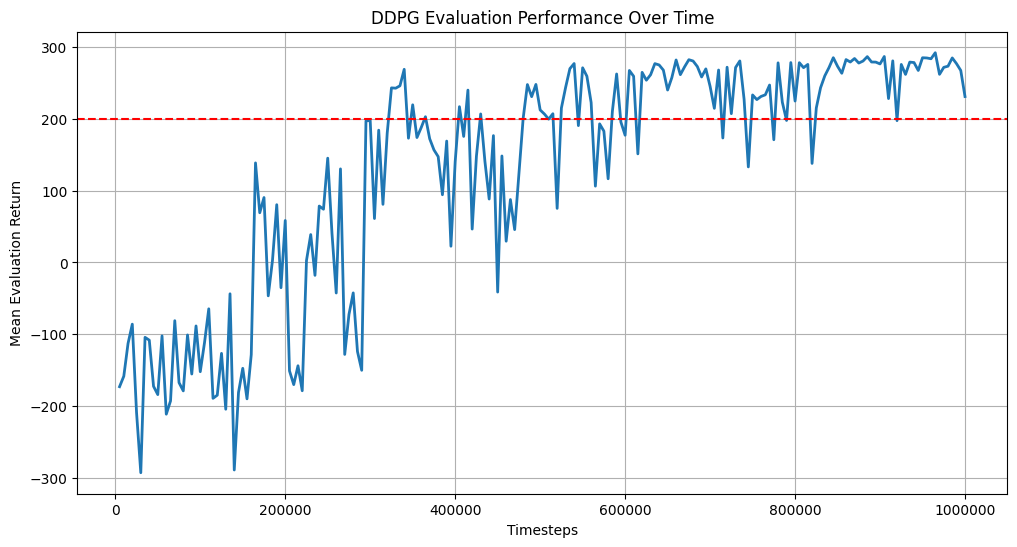

In [27]:
# Convert to DataFrame
results_df = pd.DataFrame(eval_results)

plt.figure(figsize=(12, 6))
plt.plot(results_df["timesteps"], results_df["mean_reward"], linewidth=2)  # thicker line
plt.axhline(y=200, color='red', linestyle='--', linewidth=1.5)  # red dashed horizontal line at 200
plt.xlabel("Timesteps")
plt.ylabel("Mean Evaluation Return")
plt.title("DDPG Evaluation Performance Over Time")
plt.grid(True)
plt.ticklabel_format(style='plain', axis='x')
plt.show()



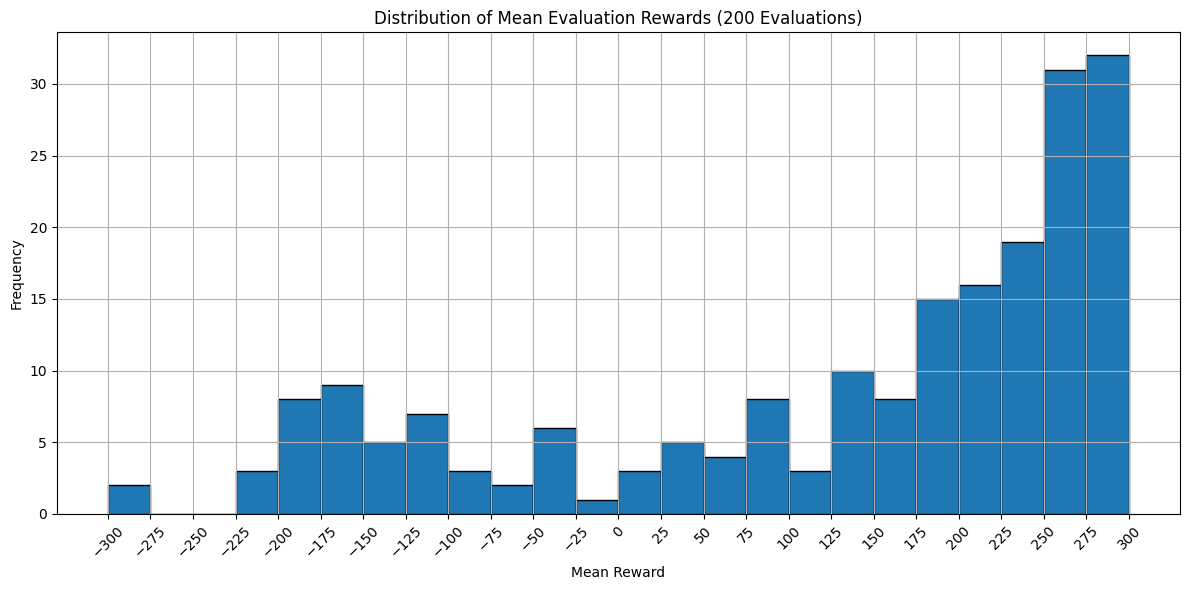

In [ ]:
min_reward = results_df["mean_reward"].min()
max_reward = results_df["mean_reward"].max()

# Create bin edges every 25 units from min to max, adding one extra bin to cover max
bins = np.arange(start=np.floor(min_reward / 25) * 25,
                 stop=np.ceil(max_reward / 25) * 25 + 25,
                 step=25)

plt.figure(figsize=(12, 6))
plt.hist(results_df["mean_reward"], bins=bins, edgecolor='k')
plt.xlabel("Mean Reward")
plt.ylabel("Frequency")
plt.title("Distribution of Mean Evaluation Rewards (200 Evaluations)")
plt.grid(True, axis='x')
plt.grid(True, axis='y', which='both')
plt.xticks(bins, rotation=45)
plt.tight_layout()
plt.show()


# PPO

In [ ]:
from stable_baselines3 import PPO
import gymnasium as gym

In [ ]:
# Test/Evaluate PPO agent using your env (with render if you want)
env = gym.make("LunarLander-v3", gravity=-10, continuous=True,
               enable_wind=True, wind_power=15.0, turbulence_power=1.5
    )
env.reset(seed=seed_value)

env.close()

In [ ]:
# Create PPO model using your existing env
ppo_model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./ppo_lunar_tensorboard/")

# Train PPO
ppo_model.learn(total_timesteps=5_000_000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_lunar_tensorboard/PPO_10


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | -359     |
| time/              |          |
|    fps             | 3109     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 103        |
|    ep_rew_mean          | -352       |
| time/                   |            |
|    fps                  | 2149       |
|    iterations           | 2          |
|    time_elapsed         | 1          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00446542 |
|    clip_fraction        | 0.0354     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.84      |
|    explained_variance   | -0.0004    |
|    learning_rate        | 0.0003     |
|   

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Number of evaluation episodes
eval_episodes = 1000
episode_returns = []

for ep in range(eval_episodes):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    steps = 0
    while not done and steps < 300:  # limit steps if you want, to match training
        action, _ = ppo_model.predict(obs, deterministic=True)
        obs, reward, done, truncated, _ = env.step(action)
        total_reward += reward
        steps += 1
        done = done or truncated
    episode_returns.append(total_reward)

avg_return = np.mean(episode_returns)
print(f"Average return over {eval_episodes} eval episodes: {avg_return:.2f}")


Average return over 1000 eval episodes: 157.16


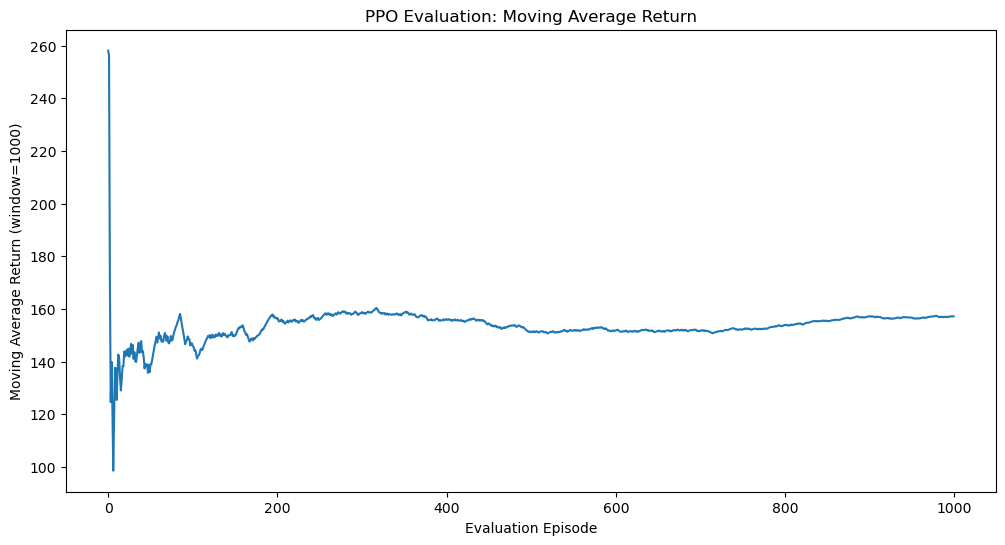

In [ ]:
window = 1000
moving_avg = [np.mean(episode_returns[max(0, i - window):i + 1]) for i in range(len(episode_returns))]

plt.figure(figsize=(12, 6))
plt.plot(moving_avg)
plt.xlabel("Evaluation Episode")
plt.ylabel(f"Moving Average Return (window={window})")
plt.title("PPO Evaluation: Moving Average Return")
plt.show()


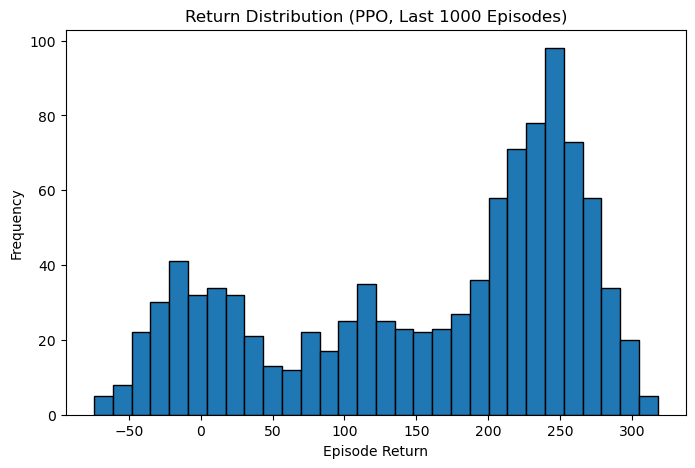

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(episode_returns, bins=30, edgecolor='k')
plt.xlabel("Episode Return")
plt.ylabel("Frequency")
plt.title("Return Distribution (PPO, Last 1000 Episodes)")
plt.show()


In [ ]:
test_env = gym.make("LunarLander-v3", gravity=-10, continuous=True,
               enable_wind=True, wind_power=15.0, turbulence_power=1.5)
test_env.reset(seed=seed_value)
test_env.close()

In [ ]:
from stable_baselines3 import PPO

# policy_kwargs = dict(
#     net_arch=[dict(pi=[256, 256], vf=[256, 256])]  # Deeper neural network for better function approximation
# )

# ppo_model = PPO(
#     "MlpPolicy",
#     test_env,                    # (Use a dedicated training env in practice)
#     n_steps=4096,                # Larger rollout for better GAE estimation
#     batch_size=256,              # Larger minibatch; try 128-256 for stability
#     gae_lambda=0.97,             # Slightly lower for less bias, more variance (helps in some envs)
#     gamma=0.99,                  # Discount factor
#     ent_coef=0.005,              # Slightly less entropy bonus late in training
#     learning_rate=1e-4,          # Slightly lower LR for more stable convergence
#     n_epochs=20,                 # More epochs for better minibatch fitting
#     clip_range=0.2,              # PPO default
#     verbose=1,
#     tensorboard_log="./ppo_lunar_tensorboard/",
#     policy_kwargs=policy_kwargs
# )

ppo_model = PPO(
    policy="MlpPolicy",
    env=env,
    n_steps=1024,        # Number of steps to run for each environment per update
    batch_size=64,       # Minibatch size
    gae_lambda=0.98,     # GAE lambda
    gamma=0.999,         # Discount factor
    ent_coef=0.01,       # Entropy coefficient
    n_epochs=4,          # Number of epochs per update
    verbose=1,
    tensorboard_log="./ppo_lunar_tensorboard/"
    # No obs normalization; stable_baselines3 does not normalize by default
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
# Train PPO
ppo_model.learn(total_timesteps=5_000_000)

Logging to ./ppo_lunar_tensorboard/PPO_13
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -356     |
| time/              |          |
|    fps             | 2864     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 1024     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102          |
|    ep_rew_mean          | -354         |
| time/                   |              |
|    fps                  | 2502         |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0011265432 |
|    clip_fraction        | 0.00146      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_v

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Number of evaluation episodes
eval_episodes = 1000
episode_returns = []

for ep in range(eval_episodes):
    obs, _ = test_env.reset()
    done = False
    total_reward = 0
    steps = 0
    while not done and steps < 300:  # limit steps if you want, to match training
        action, _ = ppo_model.predict(obs, deterministic=True)
        obs, reward, done, truncated, _ = test_env.step(action)
        total_reward += reward
        steps += 1
        done = done or truncated
    episode_returns.append(total_reward)

avg_return = np.mean(episode_returns)
print(f"Average return over {eval_episodes} eval episodes: {avg_return:.2f}")


Average return over 1000 eval episodes: 180.92


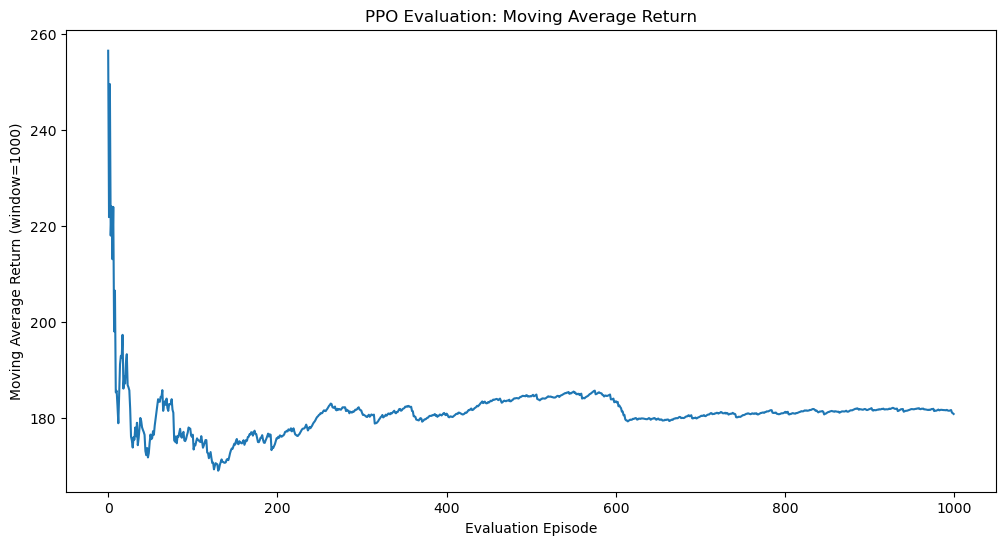

In [ ]:
window = 1000
moving_avg = [np.mean(episode_returns[max(0, i - window):i + 1]) for i in range(len(episode_returns))]

plt.figure(figsize=(12, 6))
plt.plot(moving_avg)
plt.xlabel("Evaluation Episode")
plt.ylabel(f"Moving Average Return (window={window})")
plt.title("PPO Evaluation: Moving Average Return")
plt.show()


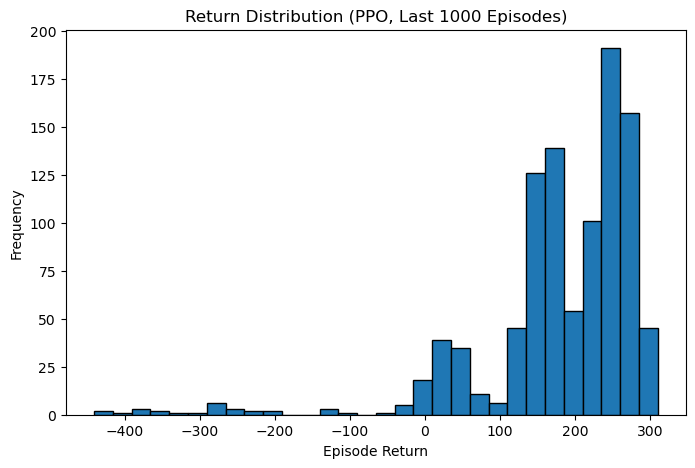

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(episode_returns, bins=30, edgecolor='k')
plt.xlabel("Episode Return")
plt.ylabel("Frequency")
plt.title("Return Distribution (PPO, Last 1000 Episodes)")
plt.show()
